# Generación de ruido para simular NeuroStrike

El objetivo de este cuaderno es generar diferentes tipos de ruido para simular el comportamiento de un NeuroStrike en el cerebro.

In [1]:
# Importamos las librerías necesarias
import os
from pathlib import Path
import numpy as np
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from plotting_Toellke import *
from read_results_1 import *
from scipy import signal
from generate_noise import *

# Guardamos la ruta de este script y con ella la de la carpeta donde están los archivos .eeg
notebook_folder: Path = Path(os.getcwd()).resolve()
eeg_folder: Path = notebook_folder / "eeg_files"

In [2]:
# Creamos un diccionario para almacenar los datos de los archivo EEG
eeg_data: Dict[str, np.ndarray] = {}

# Creamos un bucle para recorrer los archivos en la carpeta eeg_files
for file in eeg_folder.iterdir():
    if file.is_file() and file.suffix == ".txt" and "sleep" in file.name:
        data = np.loadtxt(file)                          
        name = file.stem.replace("input_nonepi_", "")  
        eeg_data[name] = data

# Guardamos los nombres de los canales en una lista
channel_names = sorted(eeg_data.keys())

# Definimos la frecuencia de muestreo
sfreq = 1024.0

## Ruido blanco

La primera aproximación es generar ruido blanco en los datos. Para añadir ruido blanco podemos cambiar dos valores: $mu$ (la media del ruido) y $sigma$ (la desviación estándar del ruido).
- $mu = 0$
- $sigma = sd(signal)$ (ruido perceptible a la vista)
- $sigma = sd(signal) \cdot 0.1$ (ruido imperceptible a la vista)

Se va a sumar el valor absoluto del ruido para no generar valores negativos de potencial, los cuales no tienen sentido en el contexto de los archivos EEG.

### Ruido blanco perceptible

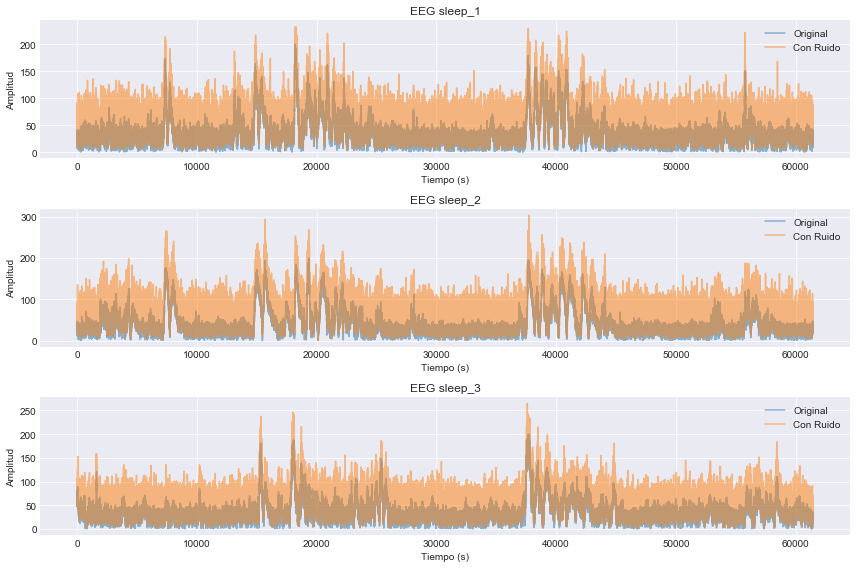

In [3]:
# Añadimos ruido blanco a los datos EEG
eeg_files_noise: Dict[str, np.ndarray] = {}
for key in channel_names:
    noise = white_noise(len(eeg_data[key]), 0, eeg_data[key].std())
    eeg_files_noise[key] = eeg_data[key] + np.abs(noise)
    
# Guardamos los datos con ruido en archivos .txt
eeg_noise_folder: Path = notebook_folder / "eeg_files_noise" / "eeg_files_noise_1"
eeg_noise_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key in channel_names:
    np.savetxt(eeg_noise_folder / f"input_nonepi_{key}_noise_1.txt", eeg_files_noise[key], fmt="%.6f")
    
# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(12, 8))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_noise[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

### Ruido blanco imperceptible

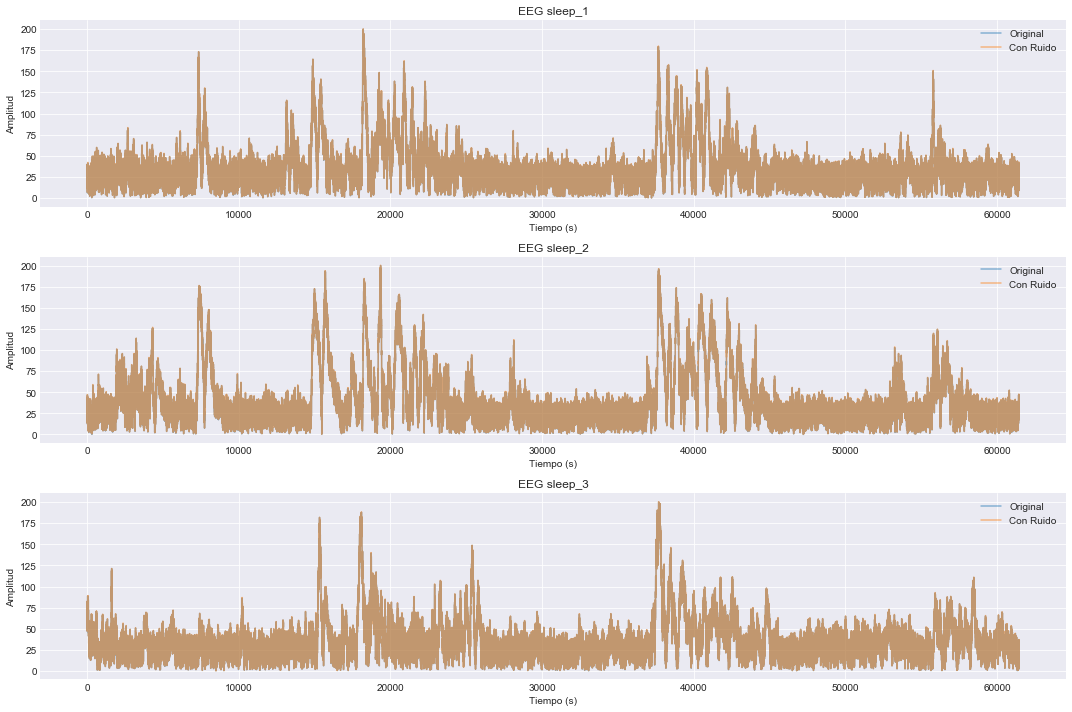

In [4]:
# Añadimos ruido blanco a los datos EEG
eeg_files_noise: Dict[str, np.ndarray] = {}
for key in channel_names:
    noise = white_noise(len(eeg_data[key]), 0, eeg_data[key].std()*.01)
    eeg_files_noise[key] = eeg_data[key] + np.abs(noise)
    
# Guardamos los datos con ruido en archivos .txt
eeg_noise_folder: Path = notebook_folder / "eeg_files_noise" / "eeg_files_noise_2"
eeg_noise_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key in channel_names:
    np.savetxt(eeg_noise_folder / f"input_nonepi_{key}_noise_2.txt", eeg_files_noise[key], fmt="%.6f")
    
# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_noise[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

## Pulso gaussiano

En la revisión bibliográfica del TFM de Lennart se menciona que los pulsos de radio frecuencia causan daños químicos y estructurales notables en el cerebro. Por lo tanto, vamos a intentar simular estos pulsos de radio frecuencia con pulsos gaussianos. Al no saber cómo interactúan directamente con las ondas EEG, simplemente los sumaremos a los archivos ya existentes. Vamos a hacer dos tipos de señales de pulsos:
- 1 Pulso gaussiano centrado y realtivamente largo
- Varios pulsos gaussianos cortos y separados entre sí

Dentro de cada experimento probaremos dos intensidades:
- 5 veces la desviación estándar de la señal
- La desviación estándar de la señal

Como queremos interferir en los SRW, en vez de sumar directamente el pulso gaussiano vamos a sumar el absoluto de este pulso. De esta forma vamos a crear grandes excitaciones de potencial.

### Pulso gaussiano único

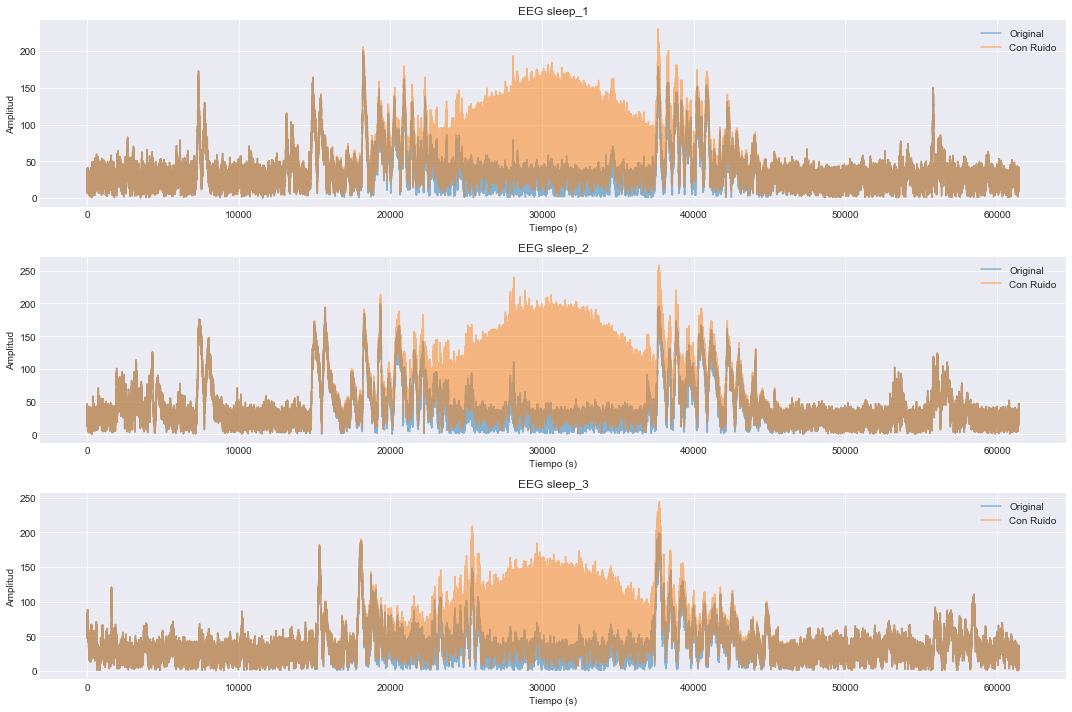

In [5]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500 # Frecuencia portadora
center = 30 # Centro del pulso
sigma = 5 # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std() * 5
    # Generamos el pulso gaussiano
    pulse = gaussian_pulse(fs, t, f_carrier, amp, center, sigma)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / "eeg_files_noise" / "eeg_files_gaussian_single_hard"
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key in channel_names:
    np.savetxt(eeg_gaussian_folder / f"input_nonepi_{key}_gaussian_single_hard.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

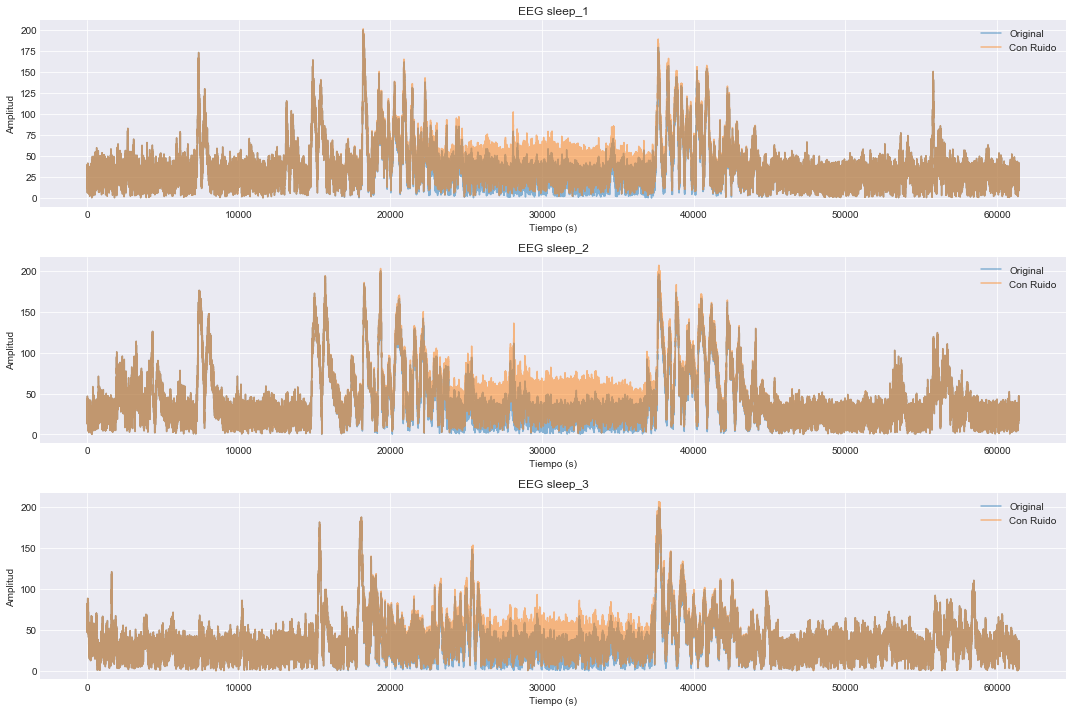

In [6]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500 # Frecuencia portadora
center = 30 # Centro del pulso
sigma = 5 # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std()
    # Generamos el pulso gaussiano
    pulse = gaussian_pulse(fs, t, f_carrier, amp, center, sigma)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / "eeg_files_noise" / "eeg_files_gaussian_single_soft"
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key in channel_names:
    np.savetxt(eeg_gaussian_folder / f"input_nonepi_{key}_gaussian_single_soft.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

### Múltiples pulsos gaussianos

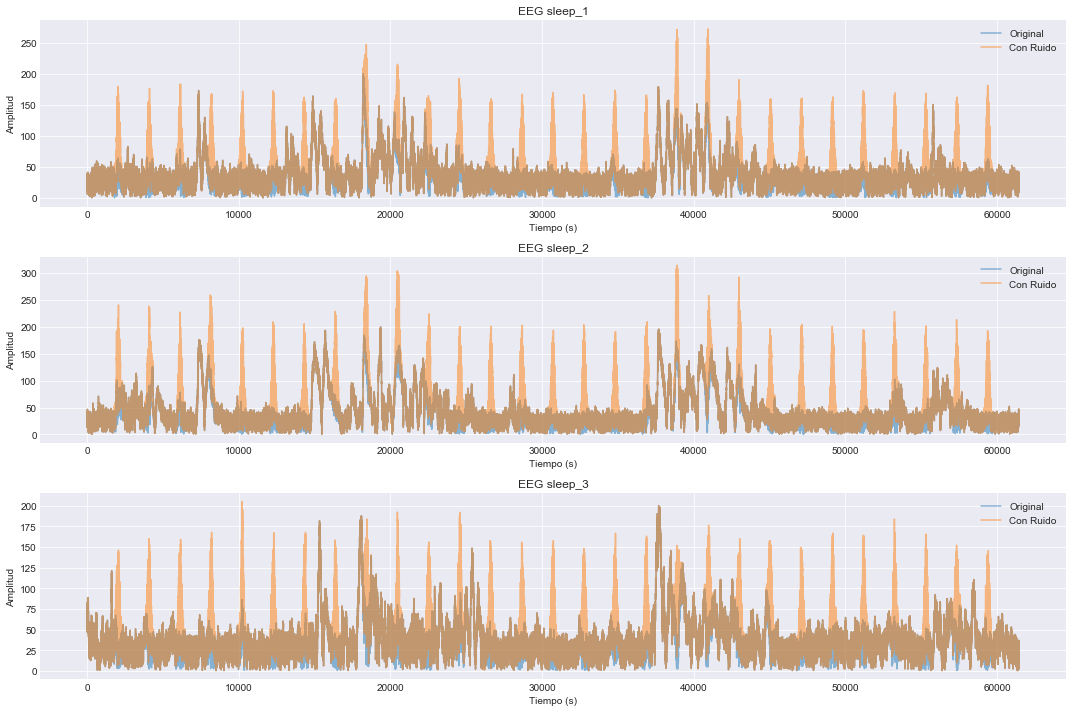

In [7]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500 # Frecuencia portadora
centers = np.arange(2, 60, 2) # Centros del pulso gaussiano
sigmas = np.ones(len(centers)) * .1 # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std() * 5
    # Generamos el pulso gaussiano
    pulse = multiple_guassian_pulses(fs, t, f_carrier, amp, centers, sigmas)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / "eeg_files_noise" / "eeg_files_gaussian_multiple_hard"
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key in channel_names:
    np.savetxt(eeg_gaussian_folder / f"input_nonepi_{key}_gaussian_multiple_hard.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

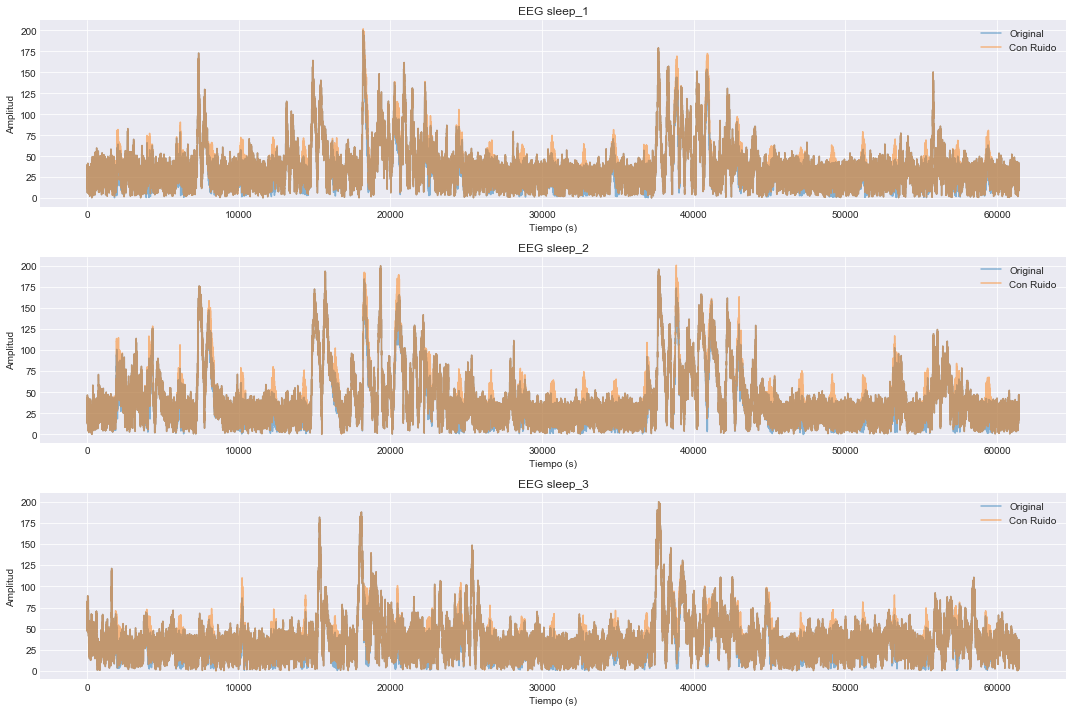

In [8]:
# Definimos las características del pulso gaussiano
fs = 1024.0  # Frecuencia de muestreo
t = np.arange(0, 60, 1/fs)  # Tiempo de 0 a 60 segundos
f_carrier = 500 # Frecuencia portadora
centers = np.arange(2, 60, 2) # Centros del pulso gaussiano
sigmas = np.ones(len(centers)) * .1 # Desviación estándar

# Generamos el pulso gaussiano y se lo sumamos a la señal EEG
eeg_files_gaussian: Dict[str, np.ndarray] = {}
for key in channel_names:
    # Definimos la amplitud del pulso
    amp = eeg_data[key].std()
    # Generamos el pulso gaussiano
    pulse = multiple_guassian_pulses(fs, t, f_carrier, amp, centers, sigmas)
    # Lo sumamos a la señal EEG
    eeg_files_gaussian[key] = eeg_data[key] + np.abs(pulse)

# Guardamos los datos con ruido en archivos .txt
eeg_gaussian_folder: Path = notebook_folder / "eeg_files_noise" / "eeg_files_gaussian_multiple_soft"
eeg_gaussian_folder.mkdir(exist_ok=True, parents=True)  # Crea la carpeta si no existe
for key in channel_names:
    np.savetxt(eeg_gaussian_folder / f"input_nonepi_{key}_gaussian_multiple_soft.txt", eeg_files_gaussian[key], fmt="%.6f")

# Finalmente graficamos los datos con ruido sobre los originales
plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(15, 10))
for i, key in enumerate(channel_names):
    plt.subplot(len(channel_names), 1, i + 1)
    plt.plot(eeg_data[key], label="Original", alpha=0.5)
    plt.plot(eeg_files_gaussian[key], label="Con Ruido", alpha=0.5)
    plt.title(f"EEG {key}")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud")
    plt.legend()
    plt.tight_layout()

# Análisis de resultados

Primero creamos una función para realizar las gráficas.

In [9]:
def plot_frequencies_psd(data_paths: list, data_names: list=[]) -> None:
    # Cremaos una lista para guardar los resultados
    results = []
    
    # Creamos una lista para guardar los nombres de los archivos
    if data_names == []:
        for data_path in data_paths:
            # Obtenemos el nombre del archivo
            file_name = os.path.basename(data_path.parent)     
            # Añadimos el nombre a la lista
            data_names.append(file_name)   
    
    # Creamos un bucle para recorrer todos los archivos de datos
    for data_path in data_paths:
        # Leemos los datos
        data = create_list_from_timeSeries(data_path)
        # Obtenemos los eventos
        all_events, swr_events, band_spectra = event_detection(data)
        # Ordenamos los eventos
        [events, filtered_events, all_spectrum_peaks, all_duration] = all_events
        [sharp_wave_ripples, sharp_wave_ripple_peaks, sharp_wave_ripple_durations] = swr_events
        # Creamos un diccionario para guardar los resultados
        recorded_events: Dict = {
            "events": events,
            "filtered_events": filtered_events,
            "all_spectrum_peaks": all_spectrum_peaks,
            "all_duration": all_duration,
            "sharp_wave_ripples": sharp_wave_ripples,
            "sharp_wave_ripple_peaks": sharp_wave_ripple_peaks,
            "sharp_wave_ripple_durations": sharp_wave_ripple_durations,
            "band_spectra": band_spectra
        }
        # Guardamos los resultados en la lista
        results.append(recorded_events)

    # Ordenamos los resultados para poder graficarlos
    # Para ello creamos dos listas vacías en la que guardaremos los resultados ordenados
    peak_frequencies = []
    psd = []
    for data_name,result,data_path in zip(data_names, results, data_paths):
        # Creamos una tupla con el nombre del archivo y los resultados
        pf_touple = (data_name, result["all_spectrum_peaks"])
        psd_touple = (data_name, result["band_spectra"])
        # Añadimos las tuplas a las listas
        peak_frequencies.append(pf_touple)
        psd.append(psd_touple)
        
    
    # Realizamos las gráficas
    plot_peak_frequencies(peak_frequencies, "Peak Frequencies", figsize=(15, 5), xrotation=45, ylim=(50,175))
    plot_power_spectral_density_bands(psd, "Power Spectral Density Bands", figsize=(15, 5), xrotation=45)
        

Una vez tenemos la función analizamos los resultados.

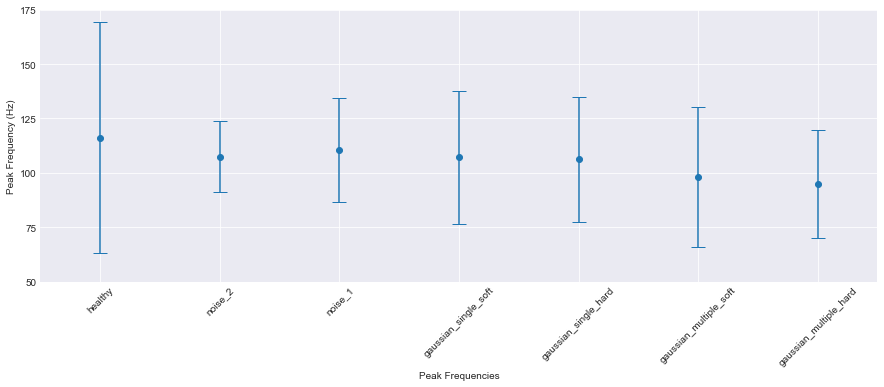

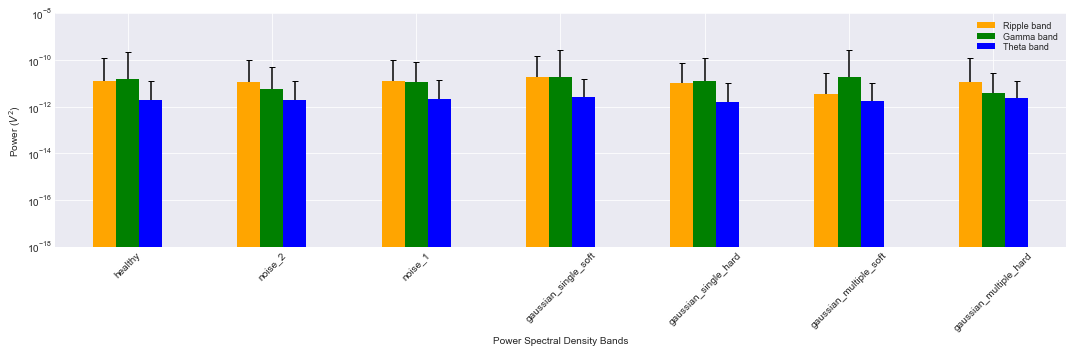

In [10]:
data_paths = [
    notebook_folder.parent / "results" / "noise_attacks_1" / "healthy" / "LFP.txt",
    notebook_folder.parent / "results" / "noise_attacks_1" / "noise_2" / "LFP.txt",
    notebook_folder.parent / "results" / "noise_attacks_1" / "noise_1" / "LFP.txt",
    notebook_folder.parent / "results" / "noise_attacks_1" / "gaussian_single_soft" / "LFP.txt",
    notebook_folder.parent / "results" / "noise_attacks_1" / "gaussian_single_hard" / "LFP.txt",
    notebook_folder.parent / "results" / "noise_attacks_1" / "gaussian_multiple_soft" / "LFP.txt",
    notebook_folder.parent / "results" / "noise_attacks_1" / "gaussian_multiple_hard" / "LFP.txt",
]

plot_frequencies_psd(data_paths)

Si comparamos los resultados de los Picos de Frecuencia de los ataques anteriores con los de los ataques de Lennart vemos lo siguiente:
- `noise_1`, `noise_2`, `gaussian_single_soft`, `gaussian_single_hard`: Se parecen a `healthy` (no hay cambios).
- `gaussian_multiple_soft`, `gaussian_multiple_hard`: Se parecen a un ataque de $N = 9k$ o de $g\_max\_e = \{57,54\}$.

Hay que tener en cuenta que los ataques combinados de $gACh$ y $gCAN$ en el TFM de Lennart dan como resultado Picos de Frecuencia similares a `healthy`.

Si comparamos los resultados de PSD de estos ataques con los ataques de Lennart vemos lo siguiente:
- `gaussian_single_soft`, `gaussian_single_hard`: Se parecen a `healthy` (no hay cambios).
- `noise_2`, `noise_1`, `gaussian_multiple_hard`: Se parecen a un ataque con $gCAN = 25$. 
- `gaussian_multiple_soft`: Se parece a un ataque de $N = 9k$ o de $g\_max\_e = 54$.